In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import os
import folium
from functions import get_plt, to_time, centroid, draw_scope, ACF
from pickle import load, dump
from geopy.distance import geodesic
from random import choices
from scipy.signal import find_peaks, periodogram
from heapq import nlargest
from time import process_time

# Data Preparation

In [2]:
# read data into a dataframe
FILES = os.listdir("/88/88")   # a list of file names under the folder

# create dataframe
COLUMNS = ["Date","Timestamp","Latitude","Longitude"]
DF = pd.DataFrame(np.zeros([1,4]), columns=COLUMNS)
count_traj = 0  # count trajectories
trj = list()
for file in FILES:
    count_traj += 1
    ds = get_plt(file)   # raw data --> numpy array with binary entries
    trj.extend([count_traj]*ds.shape[0])
    DF = DF.append(pd.DataFrame(ds,columns=COLUMNS))
print("Participant No.88 has", count_traj, "trajectories.")

# clean up entries: bytes --> string & float
df = dict()    
for column in COLUMNS:
    lst = list(DF[column])
    df[column] = [element.decode() for element in lst[1:]]
    if column=="Latitude" or column=="Longitude":
        df[column] = [float(element) for element in df[column]]
DF = pd.DataFrame(df)
DF["Trajectory"] = trj

del df,ds

Participant No.88 has 59 trajectories.


In [3]:
# uniquely indicate time as the number of seconds since 2007-01-01 00:00:00
DF["Time"] = [to_time(date,timestamp) for date,timestamp in zip(DF.Date, DF.Timestamp)]
DF.to_csv("trajectories_df.csv")
DF

Date Timestamp   Latitude   Longitude  Trajectory      Time
0      2008-09-26  10:44:08  39.975678  116.330838           1  54816248
1      2008-09-26  10:44:14  39.975665  116.330875           1  54816254
2      2008-09-26  10:44:17  39.975640  116.330875           1  54816257
3      2008-09-26  10:44:20  39.975653  116.330858           1  54816260
4      2008-09-26  10:44:23  39.975632  116.330830           1  54816263
...           ...       ...        ...         ...         ...       ...
27025  2008-10-12  08:11:10  39.977710  116.360685          59  56189470
27026  2008-10-12  08:11:12  39.977772  116.360705          59  56189472
27027  2008-10-12  08:11:14  39.977838  116.360722          59  56189474
27028  2008-10-12  08:11:16  39.977980  116.360738          59  56189476
27029  2008-10-12  08:11:36  39.980625  116.361883          59  56189496

[27030 rows x 6 columns]

# Exploratory Data Analysis

## The Velocities

In [4]:
# compute the average velocity for each trajectory in km/h
def avg_velocity(DF, i):     
    df = DF[DF["Trajectory"]==i]
    coords = [(a,b) for a,b in zip(df.Latitude, df.Longitude)]
    S = sum([geodesic(coords[j], coords[j+1]).km for j in range(len(coords)-1)])
    T = df.Time.to_list()
    T = T[-1] - T[0]
    return S/(float(T)/3600)
    
v = [avg_velocity(DF,i+1) for i in range(count_traj)]

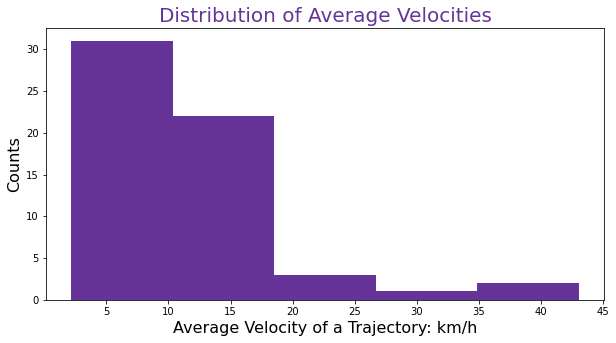

In [5]:
# Histogram of average velocity
plt.figure(figsize=(10,5))
plt.hist(v, bins=5, color="rebeccapurple")
plt.xlabel("Average Velocity of a Trajectory: km/h", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.title("Distribution of Average Velocities", fontsize=20, color="rebeccapurple")
plt.show()

## The Outliers

In [6]:
# interactive 3D plots of trajectories: (latitude, longitude) ~ time

data = list()
for i in range(max(DF.Trajectory)):
    df = DF[DF["Trajectory"]==(i+1)]
    grizzly = df.Date.to_list()
    panda = df.Timestamp.to_list()
    trace = go.Scatter3d(x = df.Time, y = df.Latitude, z = df.Longitude,
                         name = grizzly[0]+" "+panda[0],
                         line = dict(color = "darkorange"),
                         opacity = 0.8)
    data.append(trace)
        
fig = go.Figure(data = data)
fig.update_layout(scene = dict(xaxis_title = "Time",
                              yaxis_title = "Latitude",
                              zaxis_title = "Longitude"
                              ),
                  width = 700,
                  margin = dict(r=5,l=5,b=5,t=5)
                 )

fig.show()

In [9]:
# Visualize the outliers

MAP = folium.Map(location=[np.mean(DF.Latitude), np.mean(DF.Longitude)], 
                 zoom_start = 11,
                 title = "The Outliers")
    
# 1st cluster of outliers
df = DF.loc[(DF["Latitude"]>40.01) & (DF["Timestamp"]<"05:00:00")]
draw_scope(MAP, df, "Subway Morning", '#3186cc')
df = DF.loc[(DF["Latitude"]>40.01) & (DF["Timestamp"]>"05:00:00")]
draw_scope(MAP, df, "Subway Evening", 'green')

# 2nd cluster of outliers
df = DF.loc[DF["Longitude"]>116.45]
draw_scope(MAP, df, "Residential Outdoor", 'purple')

# one isolated point
folium.Marker(location=[39.9389049,116.3008483], popup="Hospital").add_to(MAP)
df = DF.loc[(DF["Date"]=="2008-10-05") & (DF["Longitude"]>116.301)]  # scope of the same day
draw_scope(MAP, df, "University", 'red')

MAP

## The Frequently Visited

In [10]:
# distribution of visits

POINTS = [(a,b) for a,b in zip(DF.Latitude,DF.Longitude)]
Samples = choices(POINTS, k=1000)  # randomly sample 1000 points
COUNT = dict()
for sample in Samples:
    # the number of visits within 100 meters at each point
    COUNT[sample] = sum([geodesic(sample,point).meters<=100 for point in POINTS]) - 1
dump(COUNT, open("SampledPointsVisits.p","wb"))
lst = [(val,key) for key,val in COUNT.items()]
lst.sort(reverse=True)
for i in range(10):    # 10 most frequently visited points in the sample
    print(lst[i]) 

(764, (39.9846766, 116.3537033))
(760, (39.9845983, 116.3536016))
(755, (39.9847883, 116.3535566))
(751, (39.9847449, 116.3537449))
(746, (39.9848099, 116.35337))
(744, (39.9846049, 116.3537316))
(741, (39.9848116, 116.353635))
(735, (39.9848399, 116.3533383))
(734, (39.9845566, 116.3536483))
(731, (39.9848716, 116.35372))


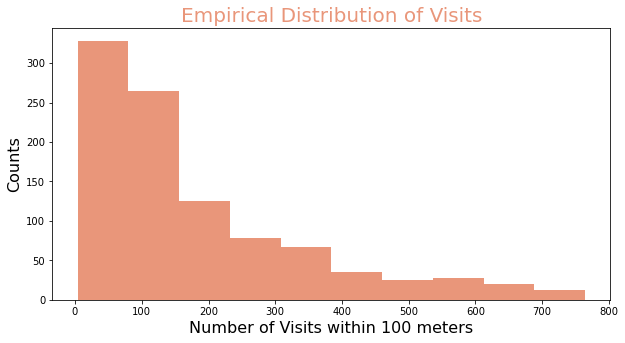

In [11]:
# Histogram of visit counts
plt.figure(figsize=(10,5))
plt.hist(COUNT.values(), bins=10, color="darksalmon")
plt.xlabel("Number of Visits within 100 meters", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.title("Empirical Distribution of Visits", fontsize=20, color="darksalmon")
plt.show()

In [12]:
# pinpoint the frequently visited

Map = folium.Map(location=[np.mean(DF.Latitude), np.mean(DF.Longitude)], 
                 zoom_start = 10,
                 title = "The Frequently Visited")

for visits,coords in lst:
    if visits>=400:
        folium.Marker(location=list(coords), popup=str(visits)).add_to(Map)

Map

# Periodicity

## Averaging & Mapping

In [13]:
# smoothing
start = min(DF.Time) + 30
TimeSeries = list()
t = start
while t<max(DF.Time):
    LST = [(lat,lng) for lat,lng,time in zip(DF.Latitude,DF.Longitude,DF.Time) if abs(time-t)<=30]
    avg_coords = (0,0)
    if len(LST)>=1:
        avg_coords = centroid(LST)   # average coordinates for every minute
    TimeSeries.append(avg_coords)
    t += 60
dump(TimeSeries, open("TimeSeries_coords.p","wb"))

# mapping
Time_Series = [a**2+b**2 for a,b in TimeSeries]   # coordinates (a,b) --> a^2 + b^2

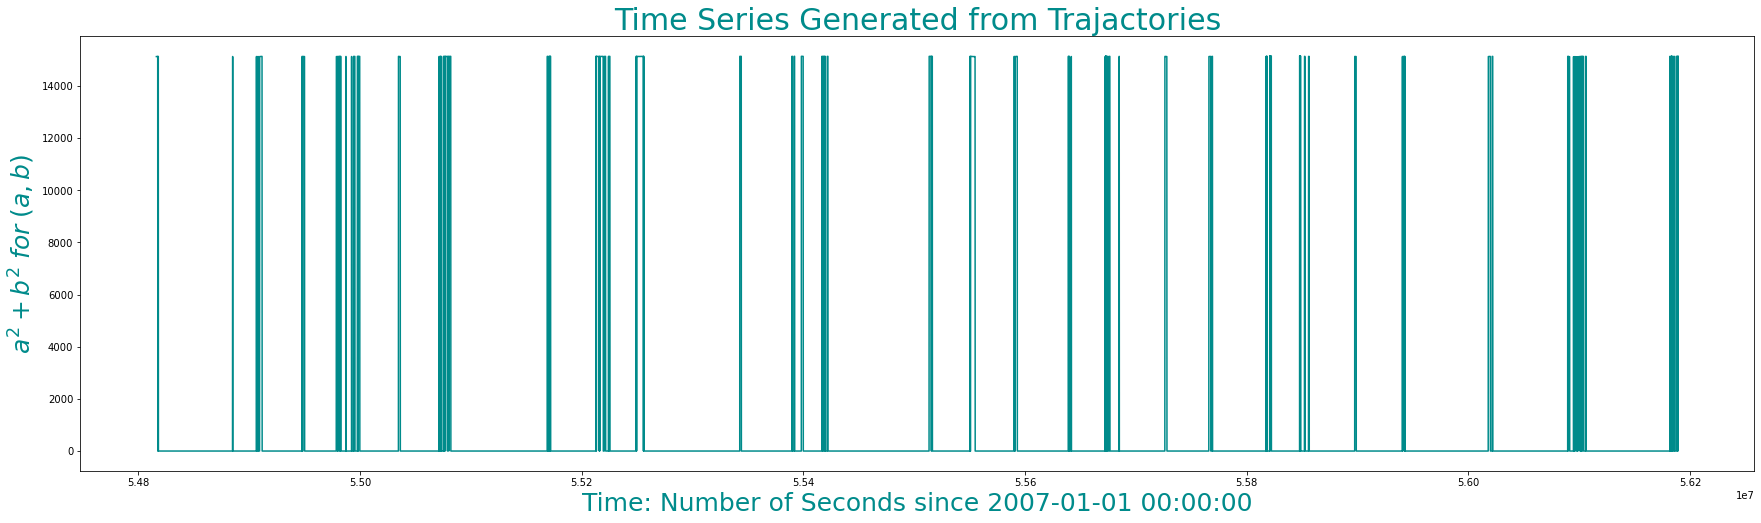

In [14]:
# visualize mapped time series

plt.figure(figsize=(30,8))
start = min(DF.Time)+30
plt.plot([start+60*i for i in range(len(TimeSeries))], Time_Series, color="darkcyan")
plt.title("Time Series Generated from Trajactories", fontsize=30, color="darkcyan")
plt.xlabel("Time: Number of Seconds since 2007-01-01 00:00:00", fontsize=25, color="darkcyan")
plt.ylabel("$a^2+b^2 \; for \; (a,b)$", fontsize=25, color="darkcyan")
plt.show()

## Auto-Correlation Function (ACF)

In [15]:
t_ACF = process_time()

acf = ACF(Time_Series)

trace = go.Scatter(x = [element for element in range(1,1+len(acf))],
                   y = acf,
                   name = r"$ACF(\tau)$",
                   line = dict(color = "darkred"),
                   opacity = 0.8)
fig = go.Figure(data = [trace],
                layout = dict(title = "Auto-Correlation Function",
                              xaxis_title = r"$Lag: \tau$",
                              yaxis_title = r"$ACF(\tau)$"
                             )
               )
fig.show()

In [16]:
res = find_peaks(np.array(acf), height=10**6, distance=30)
period_1 = np.mean(np.diff(res[0]))  
print("Period found by ACF:", period_1)

t_ACF = process_time() - t_ACF
print("Computing Time using ACF:", t_ACF, "seconds")
dump(acf, open("acf_lst.p","wb"))

Period found by ACF: 785.4137931034483
Computing Time using ACF: 124.71875 seconds


## Periodogram

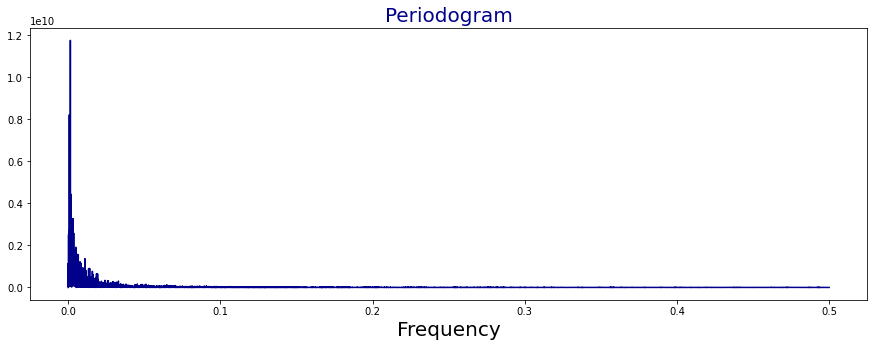

In [17]:
t_PDM = process_time()

# draw periodogram
frq,pm = periodogram(Time_Series)
plt.figure(figsize=(15,5))
plt.plot(frq,pm, color="darkblue")
plt.xlabel("Frequency", fontsize=20)
plt.title("Periodogram", fontsize=20, color="darkblue")
plt.show()

In [18]:
idx = nlargest(2, range(len(pm)), pm.take)
periodogramPeriods = [1/frq[id] for id in idx]
print("Periods found by periodogram:", periodogramPeriods)

t_PDM = process_time() - t_PDM
print("Computing Time using periodogram:", t_PDM, "seconds")

Periods found by periodogram: [715.21875, 1430.4375]
Computing Time using periodogram: 0.21875 seconds


# Conclusion